In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

import glob
import os

import warnings
from PIL import Image

# PIL 경고 메시지 OFF
warnings.simplefilter('ignore', Image.DecompressionBombWarning)
Image.MAX_IMAGE_PIXELS = 1000000000

---
## Progress Bar 함수

In [2]:
# 프로그레스 바를 출력하는 함수
def print_progress_bar(iteration, total, prefix='Complete', suffix='', decimals=5, length=100, fill='█', print_end='\r'):
    """
    Parameters:
        iteration (int): 현재 진행된 작업 수
        total (int): 전체 작업 수
        prefix (str): 프로그레스 바 앞에 추가할 텍스트
        suffix (str): 프로그레스 바 뒤에 추가할 텍스트
        decimals (int): 백분율에서 소수점 이하 자릿수
        length (int): 프로그레스 바의 총 길이 (글자 수)
        fill (str): 프로그레스 바의 채우는 문자
        print_end (str): 프로그레스 바 출력 후 커서의 위치를 조정하는 문자열
    """
    # 현재 진행된 작업의 백분율 계산
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))

    # 프로그레스 바의 채워진 길이 계산
    filled_length = int(length * iteration // total)

    # 프로그레스 바 출력
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=print_end)

    # 모든 작업이 끝나면 줄바꿈
    if iteration == total:
        print()

---

## 데이터셋 정의

In [232]:
# 데이터셋
class product_img_detection_dataset(Dataset):
    images = []

    def __init__(self, root_dir, train_transform = None, val_transform = None, is_train_phase = True):
        self.root_dir = root_dir

        for lable in os.listdir(root_dir):
            img_list = glob.glob(root_dir + "/" + lable + "/*/*")
            self.images.extend([(img, lable) for img in img_list])
        
        # train 페이즈, val 페이즈에서 다른 transformer를 적용하기 위해
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.is_train_phase = is_train_phase

        self.images = self.validate_images(self.images)

    # 열 수 없는 이미지들은 데이터셋에 로드하지 않음
    def validate_images(self, img_list):
        valid_imgs = []
        for idx, (img, label) in enumerate(img_list):
            try:
                im = Image.open(img)
                im.verify()
                valid_imgs.append((img, label))
            except:
                print(f'\r{idx+1} / {len(img_list)}: {img}', end="\r")  # 열 수 없는 이미지의 경우 "이미지인덱스/전체이미지개수" 출력
        return valid_imgs
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image, label = self.images[idx]

        try:
            image = Image.open(image).convert('RGB')

            if self.is_train_phase:
                if self.train_transform:
                    image = self.train_transform(image)
            else:
                if self.val_transform:
                    image = self.val_transform(image)
            
            if label == "TRUE":
                label = 1
            elif label == "FALSE":
                label = 0
        
        except:
            # 알 수 없는 오류가 발생했을 때, dummy값으로 black 이미지와 0을 레이블로 반환
            dummy_image = torch.zeros([3, 224, 224])
            dummy_label = 0
            return dummy_image, dummy_label

        return image, label

## 트랜스포머(전처리) 정의

In [230]:
data_transforms = {
    "train" : transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),  # 훈련 단계에서는 Random으로 크롭
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # 평가 단계에서는 중앙으로 크롭
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## 데이터셋 불러오기

In [ ]:
dataset_path = r"D:/FAVORFIT/product_img_detect_data"

full_dataset = product_img_detection_dataset(dataset_path.replace("\\","/"), 
                                             train_transform = data_transforms["train"],
                                             val_transform = data_transforms["val"])

In [24]:
# 8:2로 (train, val) subdataset 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [25]:
# subdataset의 is_train_phase 변수 조절 (train, val 페이즈마다 다른 transformer 적용 위해)
train_dataset = torch.utils.data.Subset(full_dataset, train_dataset.indices)
train_dataset.dataset.is_train_phase = True
val_dataset = torch.utils.data.Subset(full_dataset, val_dataset.indices)
val_dataset.dataset.is_train_phase = False

## 데이터로더 정의

In [55]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

---
## Resnet50 사전학습 모델 불러오기

In [56]:
model = models.resnet50(pretrained=True)

In [57]:
# out이 2개가 되도록 마지막 레이어 추가
num_ftrs = model.fc.in_features
models.fc = nn.Linear(num_ftrs, 2)

## 손실함수, 옵티마이저
- lr과 momentum은 고민 안 했음

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## GPU 사용 준비

In [62]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 학습 시작
- Epoch 3 때 멈췄어야 했다..

In [64]:
results = []    # Epoch 마다 Loss, Acc, Error 저장

num_epochs = 50 # Epochs 수

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # train 페이즈, val 페이즈
    for phase in ['train', 'val']:
        if phase == 'train':
            dataloader = train_dataloader
            model.train()
        else:
            dataloader = val_dataloader
            model.eval()


        running_loss = 0.0
        running_corrects = 0
        iteration = 0
        total = len(dataloader)
        error_counter = 0


        # iterate
        for inputs, labels in dataloader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # train일 경우 가중치 업데이트
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Loss, Acc 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # 프로그레스바 출력
            iteration += 1
            print_progress_bar(iteration, total)

        epoch_loss = running_loss / (len(dataloader.dataset) - error_counter)
        epoch_acc = running_corrects.double() / (len(dataloader.dataset) - error_counter)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')



        # 결과 저장
        results.append({
            'epoch': epoch+1,
            'phase': phase,
            'loss': epoch_loss,
            'accuracy': epoch_acc.item(),
            'error' : error_counter
        })

Epoch 1/50
Complete |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% 
train Loss: 0.5366 Acc: 0.7776
Complete |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% 
val Loss: 0.4326 Acc: 0.8088
Epoch 2/50
Complete |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% 
train Loss: 0.4048 Acc: 0.8162
Complete |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% 
val Loss: 0.4023 Acc: 0.8224
Epoch 3/50
Complete |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% 
train Loss: 0.3840 Acc: 0.8274
Complete |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00000% 
val Loss: 0.3866 Acc: 0.8303
Epoch 4/50
Complete |██████████████████████

KeyboardInterrupt: 

## 모델 저장하기

In [ ]:
torch.save(model.state_dict(), 'resnet_11epoch_loss.pth')

---
## 결과 확인

In [235]:
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [236]:
# 이미지 전처리, tensor로 리턴
def img_preprocess(img_path):
    image = Image.open(img_path).convert('RGB')
    preprocessed_img_tensor = data_transforms["val"](image).to(device)

    return preprocessed_img_tensor

# 이미지 시각화
def img_show(preprocessed_img_tensor):
    img_to_show = preprocessed_img_tensor.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(np.clip(img_to_show,0,1))


# 모델 실행
def run_model(model, preprocessed_img_tensor):

    model.eval()
    outputs = model(preprocessed_img_tensor.unsqueeze(0))
    result = torch.max(outputs, 1)

    return "product" if result.indices.item()==True else "not product" 


In [237]:
model = torchvision.models.resnet50()
model.load_state_dict(torch.load("resnet_11epoch_loss.pth"))
model = model.to(device)

Below image is *** not product ***


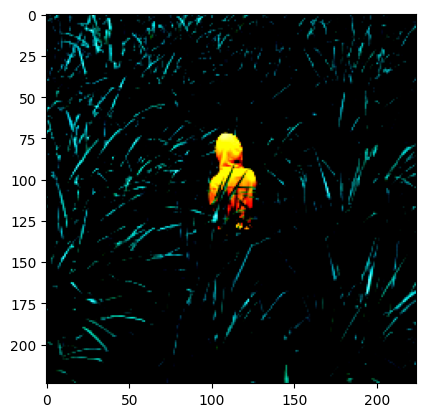

In [239]:
# 이미지 path 입력
img_path = r"D:\FAVORFIT\product_imgs_each_tags\unsplash\HD배경/195_Perso.png"



preprocessed_img_tensor = img_preprocess(rf"{img_path}".replace("\\","/"))
is_product = run_model(model, preprocessed_img_tensor)

print("Below image is ***", is_product, "***")
img_show(preprocessed_img_tensor)